# Trying to extract the images from dicom files again 


In [1]:
import os
import sys
import shutil
import pydicom as dcm
import matplotlib.pyplot as plt
from PIL import Image
from collections import namedtuple
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

from DataPreparationModule import ct_image_extraction as ct_prep

## Example with one dicom file

In [3]:
"""
Read in the dicom file
"""
negative_dicoms_path = '/Volumes/My Passport for Mac/debug_dataset/negative/'
negative_dicom_filename = '100160-2000.dcm'
example_dicom = ct_prep.read_in_dicom_file(
    dicom_path=negative_dicoms_path,
    dicom_filename=negative_dicom_filename
)

In [4]:
"""
Display the properties of the example dicom file
"""
print(example_dicom)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.55.152392326075952650111981232235504795156
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.152392326075952650111981232235504795156
(0008, 0020) Study Date  

In [5]:
"""
display the photometric interpretation of the example image
All of the CT slices should have MONOCHROME2
My code double checks this and raises and exception otherwise
"""

example_dicom.PhotometricInterpretation

'MONOCHROME2'

In [6]:
"""
modality 'look up table'

This is a processing step that converts the values in the raw pixel array to
measurments in units that have physical meaning

for CT scans, this is Hounsfield Units. 

When we apply the modality lookup table to the raw pixel array, 
we get 'Hounsfield arrays'
"""
#
example_raw_array = example_dicom.pixel_array
example_houndsfield_array = ct_prep.modality_lut(pixel_array=example_raw_array,
                                                dicom_file=example_dicom)


In [7]:
"""
Applying lung window to example image.

Windowing refers to changing two things: 

1. (WindowWidth) The range of hounsfield units that are represented by different shades of gray
2. (WindowCenter) The midpoint of the range. Sometimes referred to as window level

'Lung Window' refers to WindowWidth=1500, WindowCenter=-600
"""

lung_window = (1500, -600)
lung_array = ct_prep.apply_ct_window(example_houndsfield_array, lung_window)

Text(0.5, 1.0, 'Lung Window')

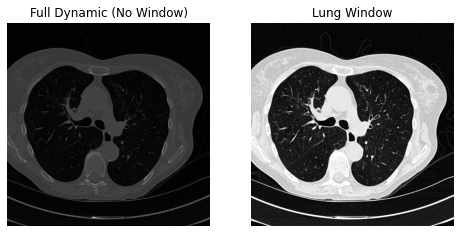

In [8]:
"""
Plotting. both default window and lung window to demonstrate the differences
"""


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 16))
#fig.set_title('Example CT Preprocessing')
ax1.imshow(example_houndsfield_array, cmap='gray')
ax1.axis('off')
ax1.set_title('Full Dynamic (No Window)')
ax2.imshow(lung_array, cmap='gray')
ax2.axis('off')
ax2.set_title('Lung Window')

This looks good, but it actually lacks detail and needs to be converted to a full image. I will do this now and show you the difference between the array plotted here and the image version. 

In [9]:
"""
How the range of the current lung window image

The image is grayscale so it is just one channel
It is also 'normalized' so that all values are between 0 and 1
"""

print('max: {}'.format(lung_array.max()))
print('min: {}'.format(lung_array.min()))

max: 1.0
min: 0.21733333333333332


In [10]:
lung_array_as_image = ct_prep.create_image_from_array(lung_array)

Text(0.5, 1.0, 'CT Image from Dicom array')

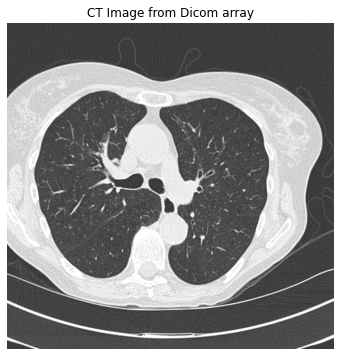

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
ax.axis('off')
ax.imshow(lung_array_as_image)
ax.set_title('CT Image from Dicom array')

As one can see, the image is more detailed. These images will now be extracted programmatically and saved to file

## Programmatic Pre-Processing 

In the following cells, I am going to apply the same preprocessing as in the example to all the ct slices I will use for the experiments. 

In [12]:
path2dicoms = '/Volumes/My Passport for Mac/debug_dataset/positive'
dicoms = [file for file in os.listdir(path2dicoms) if not ('._' in file) and not (file[0] == '.') and (file != 'arrays')]

In [13]:
print(len(dicoms))

478


In [14]:
savepath = '/Volumes/My Passport for Mac/debug_dataset/positive/positive_images'
names = []
for dicom_file in dicoms:
    #print(dicom_file)
    try:
        lung_window_image, no_window_image, savefile_name = ct_prep.extract_images(path2slice=path2dicoms,
                                                         slice_filename=dicom_file)
        names.append(savefile_name)
        print(type(lung_window_image))
        #display_unwindowed_and_lung(extracted_images)
        ct_prep.save_image(lung_window_image, savepath, savefile_name)
    except:
        continue
    
assert(len(set(names)) == len(names))
    

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.

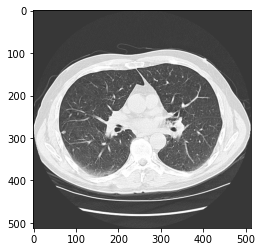

In [15]:
plt.imshow(lung_window_image)